In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_curve, auc, f1_score

In [3]:
data_path = 'data'
submission_path = './'

In [4]:
# Load data
df_test = pd.read_csv(os.path.join(data_path, 'test.csv'))
df_test_labels = pd.read_csv(os.path.join(data_path, 'test_labels.csv'))
df_ml = pd.read_csv(os.path.join(submission_path, 'ml_predictions.csv'))
df_rules = pd.read_csv(os.path.join(submission_path, 'rules_predictions.csv'))
df_hybrid = pd.read_csv(os.path.join(submission_path, 'hybrid_predictions.csv'))

In [5]:
# Rename columns
df_ml.rename(columns={'spoof_flag_ml': 'spoofed'}, inplace=True)
df_hybrid.rename(columns={'spoof_flag_hybrid': 'spoofed'}, inplace=True)
df_rules.rename(columns={'spoof_flag_rules': 'spoofed'}, inplace=True)

## Metrics

### Precision, recall and F1 score

In [6]:
# Calculate precision, recall, F1 score
df_results = {
    'ML': df_ml,
    'Rules': df_rules,
    'Hybrid': df_hybrid
}
for method, df in df_results.items():
    tp = np.sum((df['spoofed'] == 1) & (df_test_labels['spoofed'] == 1))
    fp = np.sum((df['spoofed'] == 1) & (df_test_labels['spoofed'] == 0))
    fn = np.sum((df['spoofed'] == 0) & (df_test_labels['spoofed'] == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{method} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")



ML - Precision: 0.9378, Recall: 0.6526, F1 Score: 0.7696
Rules - Precision: 0.4602, Recall: 0.7507, F1 Score: 0.5706
Hybrid - Precision: 0.4602, Recall: 0.7507, F1 Score: 0.5706


Some observation
- ML model has the best precision (94%), which means the flagged data are very likely to be spoofed. But the recall is only 65%, meaning quite a large number of spoofed events are not detected.
- Rules based model on the other hand has better recall (75%), meaning it successfully caught a larger majority of spoofing events, at least compared to ML model. However it has more false positives (low precision of 46%), which means a lot of false alarms, which can affect legitimate users.

Why do rules-based method and hybrid method have the exact same metrics? 


Let's see the mean of the scores by ML model

In [7]:
df_ml['spoof_score_ml'].mean()

np.float64(0.2853066666666667)

And the mean scores of rules-based model

In [8]:
df_rules['spoof_score_rules'].mean()

np.float64(0.565)

- The rules-based system outputs a score of 1.0 whenever any rule is triggered. Since rules based approach have a high recall (0.75) but low precision, it means the rules are triggered frequently, which results in many 1s. 
- The hybrid score is a simple average of ML score and rules score. Whenever the rule is triggered (rules score = 1), the hybrid score will be `(ml_score + 1) / 2`. Since ML score is always between 0 and 1, the hybrid score will always be greater than 0.5. Then with thresholding level of 0.5, it will be flagged as spoofed. So basically the hybrid model is defaulting to the output of the rules-based model.

For a better hybrid model, we can
- Tune the weighted average instead of using 50/50. This would make the ML score more influential and can likely improve precision.
- Use rules-based model as first pass and ML as second pass. If rules-based model triggered, we will use ML score, otherwise just use rules-based.
- Use triggered rules as a feature for the ML model.


### PR Curve

In [10]:
y_true = df_test_labels['spoofed']
y_scores_ml = df_ml['spoof_score_ml']

In [12]:
# PR curve points
precision_ml, recall_ml, thresholds_ml = precision_recall_curve(y_true, y_scores_ml)

# F1 scores at different thresholds
f1_scores = 2 * (precision_ml * recall_ml) / (precision_ml + recall_ml)
f1_scores = np.nan_to_num(f1_scores)  # Replace NaN with 0

# Find the threshold that gives the maximum F1 score
best_f1_index = np.argmax(f1_scores)
best_threshold_ml = thresholds_ml[best_f1_index] if best_f1_index < len(thresholds_ml) else 1.0
best_precision_ml = precision_ml[best_f1_index]
best_recall_ml = recall_ml[best_f1_index]
best_f1_ml = f1_scores[best_f1_index]

# Calculate AUC-PR
auc_pr_ml = auc(recall_ml, precision_ml)

# For rules model
y_scores_rules = df_rules['spoof_score_rules']
precision_rules, recall_rules, thresholds_rules = precision_recall_curve(y_true, y_scores_rules)
f1_scores_rules = 2 * (precision_rules * recall_rules) / (precision_rules + recall_rules)
f1_scores_rules = np.nan_to_num(f1_scores_rules)
best_f1_index_rules = np.argmax(f1_scores_rules)
best_threshold_rules = thresholds_rules[best_f1_index_rules] if best_f1_index_rules < len(thresholds_rules) else 1.0
best_precision_rules = precision_rules[best_f1_index_rules]
best_recall_rules = recall_rules[best_f1_index_rules]
best_f1_rules = f1_scores_rules[best_f1_index_rules]
auc_pr_rules = auc(recall_rules, precision_rules)

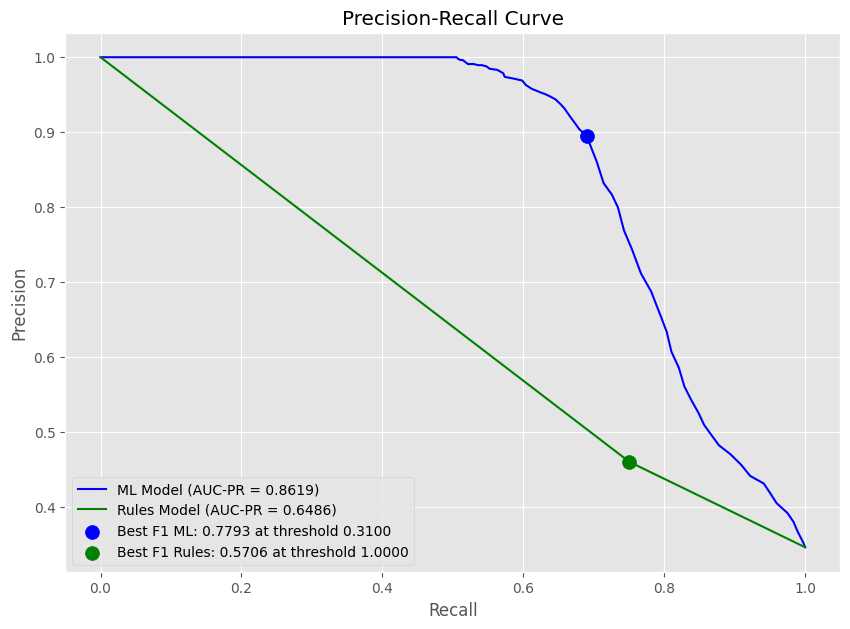

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))

plt.plot(recall_ml, precision_ml, label=f'ML Model (AUC-PR = {auc_pr_ml:.4f})', color='blue')
plt.plot(recall_rules, precision_rules, label=f'Rules Model (AUC-PR = {auc_pr_rules:.4f})', color='green')  

plt.scatter(best_recall_ml, best_precision_ml, color='blue', marker='o', s=100,
            label=f'Best F1 ML: {best_f1_ml:.4f} at threshold {best_threshold_ml:.4f}')
plt.scatter(best_recall_rules, best_precision_rules, color='green', marker='o', s=100,
            label=f'Best F1 Rules: {best_f1_rules:.4f} at threshold {best_threshold_rules:.4f}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)  # This line shows the grid

plt.show()


From the PR curve, we can see
- ML model outperforms the rules-based model significantly (0.96 vs 0.65 in AUC). The curve for ML model is consistently higher and to the right, which means better precision at every threshold.
- There is a large gap between the 2 curves, which is expected. ML model might be capturing complex sensor noise or patterns that simple rules cannot
- The ML curve maintains high precision at lower recall levels, which means that the ML model is good at identifying obvious spoofing events. 
- However precision drops quite sharply after recall = 0.7. This suggests there are some complex spoofing events that are harder to distinguish.

## Error analysis

In [19]:
df_train = pd.read_csv(os.path.join(data_path, 'train.csv'))

In [28]:
# Get 5 false positives and 5 false negatives from the ML model, merge with train to get the features also
df_ml['true_label'] = df_test_labels['spoofed']
false_positives_ml = df_ml[(df_ml['spoofed'] == 1) & (df_ml['true_label'] == 0)].head(5)
false_negatives_ml = df_ml[(df_ml['spoofed'] == 0) & (df_ml['true_label'] == 1)].head(5)


In [29]:
# Merge with train data to get features
df_false_positives_ml = pd.merge(false_positives_ml, df_test, on='event_id', how='left')
df_false_negatives_ml = pd.merge(false_negatives_ml, df_test, on='event_id', how='left')

In [ ]:
# convert to json
# df_false_positives_ml.to_json('false_positives_ml.json', orient='records', lines=True)
# df_false_negatives_ml.to_json('false_negatives_ml.json', orient='records', lines=True)

False positives examples

In [32]:
df_false_positives_ml

,event_id,spoof_score_ml,spoofed,is_spoofed_ground_truth,true_label,installation_id,latitude,longitude,timestamp_unix,horizontal_accuracy,altitude,speed,bearing,pressure_hpa,mock_location_enabled,device_is_charging,wifi_bssid,cell_tower_id,num_satellites,vertical_accuracy,ambient_light_lux
0,d436e615-e640-4b28-8f9a-34e51b5c92e5,0.40,1,0,0,875ddf9e-fcde-453b-8349-edf148fb6951,40.796700,-74.013831,1766743638,17.031549,39.078199,1.466237,147.667885,1009.672435,False,False,NaN,420-55-9081-7859,20,20.778224,220.336131
1,bc22ccc1-8da8-41d0-83ea-52c8e446d461,0.38,1,0,0,71e6def5-e53b-4441-84b3-fe70494e5567,40.616599,-74.007260,1766743448,2.000000,53.719919,1.176676,131.986992,1006.092087,False,False,NaN,420-55-4252-6804,14,23.992997,131.026539
2,fe02a8a2-e82d-419e-ae1e-ec428f446191,0.36,1,0,0,b589f403-b6e6-46f9-a215-c073ad7069fb,40.703714,-73.963429,1766743578,13.633510,50.761166,1.385804,280.240889,1006.867714,False,False,NaN,420-55-4083-4722,12,10.983824,249.822988
3,9f66bc2e-f2b7-4f4d-b02c-88149bf414f7,0.46,1,0,0,e94d5b0f-2dc3-48ab-b3f5-ce7ba45862d0,40.717129,-74.048751,1766743528,3.828116,61.755647,9.912088,334.163523,1006.264602,False,False,NaN,420-55-3702-5041,14,18.398797,272.728448
4,a5c1a326-2f06-4c38-87ca-8692c07044ff,0.58,1,0,0,5b852930-c558-4ce1-8761-0fd6e0ae4344,40.783002,-73.976259,1766743588,11.679614,56.133995,1.348295,157.370187,1007.737435,False,False,NaN,420-55-4083-4722,16,16.130252,238.168515


False negatives examples

In [36]:
df_false_negatives_ml

,event_id,spoof_score_ml,spoofed,is_spoofed_ground_truth,true_label,installation_id,latitude,longitude,timestamp_unix,horizontal_accuracy,altitude,speed,bearing,pressure_hpa,mock_location_enabled,device_is_charging,wifi_bssid,cell_tower_id,num_satellites,vertical_accuracy,ambient_light_lux
0,d1270765-5d39-4f6c-a63b-939d4cf13290,0.29,0,1,1,05eb504c-b698-4e21-9ca3-57eff6740b4b,40.793407,-73.915567,1766743728,15.129599,57.788534,0.000000,0.000000,1003.484993,False,False,NaN,420-55-7596-8472,12,19.690095,136.793347
1,efcbc1c7-19c4-4d4f-9f47-02999d905249,0.06,0,1,1,6208ea36-df10-483a-a961-5d2c274e5f24,40.703843,-73.948827,1766743408,14.035643,68.531940,1.130479,288.962041,1004.068756,False,False,NaN,420-55-2908-6901,11,21.602901,175.460312
2,ffbd5d10-044f-4d6d-8939-b33a550fc8de,0.12,0,1,1,8c024d81-5488-40ee-865d-e0610ce03905,40.690512,-73.941630,1766743598,15.441016,49.549634,0.000000,0.000000,1008.260830,False,True,NaN,420-55-9636-3854,17,3.858546,251.459559
3,fc7acd54-e048-4c5f-937b-a261ef6318ae,0.23,0,1,1,698cbd1d-f647-4677-83e9-2a2598dcf13f,40.735788,-74.098360,1766743668,12.539873,54.757683,0.000000,0.000000,1005.875107,False,False,0a:1b:2c:3d:4e:08,420-55-4008-4997,9,19.447263,176.366361
4,161bcc86-e174-49e5-9f67-389ef62e78b5,0.19,0,1,1,9e75f61c-1ac3-47dc-83fb-7e44241801b6,40.790128,-73.968532,1766743558,12.881011,48.540646,1.449734,321.679358,1005.663149,False,False,NaN,420-55-6851-2029,18,14.717809,188.947594


### False positives patterns

- Low speed/indoor: 4 out of 5 events show speeds between 1.1 and 1.5m/s (walking) and all 6 have ambient_light_lux between 130 and 270 (indoor lighting)
- High satellite count: all have high satellite count and mock_location is false
- In indoor or slow-walking scenarios, sensor noise is minimal, so the model might be misinterpreting the clean signals as software simulated injection
- One event has significantly higher speed (9.9 m/s) and high score (0.46). This suggests the model might also be suspicious of rapid transitions with high precision

#### Tuning
- If more FPs occur at walking speed, we can use dynamic threshold: increase threshold when the speed is small (2m/s for instance)
- For clean signals: maybe add some engineered features like variance of ambient_light or pressure. If they fluctuates then more likely a real event.

### False negatives patterns
- 3 out of 5 events have a speed of 0.0 and a bearing of 0.0. The model likely treats stationary devices as "low risk." Attackers could exploit this by spoofing a fixed location.
- 2 remaining events show speeds of 1.1–1.4 m/s. These attackers are likely using spoofing apps that simulate a natural walking pace. Because the speed and bearing look realistic and the horizontal_accuracy is average.

#### Tuning
- Lowering the threshold means lower precision and hurting user experience with false alarms, 
- Instead we can add more features derived from sensor variance and environmental consistency. For example, cross check the local weather data with the GPS coordinates at corresponding timestamp to see pressure is consistent.